## Importar librerias necesarias

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import warnings


## Importar dataset del DataSet Internet

In [2]:
warnings.filterwarnings('ignore')

# Cargar el archivo Excel
file_path = 'datasets/Internet.xlsx'
file_path_tv = 'datasets/Television.xlsx'
data = pd.ExcelFile(file_path)

# Mostrar las pestañas del archivo Excel
sheet_names = data.sheet_names
sheet_names


['Velocidad_sin_Rangos',
 'Velocidad % por prov',
 'Totales VMD',
 'Accesos_tecnologia_localidad',
 'Totales Accesos Por Tecnología',
 'Accesos Por Tecnología',
 'Dial-BAf',
 'Totales Dial-BAf',
 'Penetracion-poblacion',
 'Penetracion-hogares',
 'Penetracion-totales',
 'Totales Accesos por velocidad',
 'Accesos por velocidad',
 'Ingresos']

> Se importa el dataset y se hace una impresion de todas las pestañas del archivo.

### Nota:

<p> se reqalizo una revision preliminar del los datos a traves de excel y por la cantidad de de valores faltantes existentes en el la seccion 'Acc_vel_loc_sinrangos' se decidio dejar fuera del registro.</p>

In [3]:
for sheet in sheet_names:
    if sheet == 'Acc_vel_loc_sinrangos':
        continue
    df = pd.read_excel(file_path, sheet_name=sheet)
    print(f"--- {sheet} ---")
    print(df.head())
    print("\n")

--- Velocidad_sin_Rangos ---
      Año  Trimestre        Provincia    Otros  0,256 Mbps  0,375 Mbps  \
0  2023.0        4.0     Buenos Aires  93351.0        19.0         0.0   
1  2023.0        4.0  Capital Federal      0.0        31.0         0.0   
2  2023.0        4.0        Catamarca     77.0         0.0         0.0   
3  2023.0        4.0            Chaco   4040.0         0.0         0.0   
4  2023.0        4.0           Chubut  16589.0         8.0         0.0   

   0,625 Mbps  0,5 Mbps  0,512 Mbps  0,75 Mbps  ...  2048 Mbps  2529 Mbps  \
0         0.0   26703.0       187.0     4611.0  ...        0.0        0.0   
1         0.0     451.0        34.0     1307.0  ...        0.0        0.0   
2         0.0      34.0        37.0        0.0  ...        0.0        0.0   
3         0.0     234.0         2.0        0.0  ...        0.0        0.0   
4         0.0      69.0        34.0      836.0  ...        0.0        0.0   

   3072 Mbps  4000 Mbps  5000 Mbps  5125 Mbps  6000 Mbps  7000 

> Se uso el metodo head(5) de pandas para revisar a detalle como estan compuestas la columnas de datos en cada tabla con el fin de tener una idea de como pueden relacionarse entre ellos.

In [4]:
nulos = {}
for sheet in sheet_names:
    data = pd.read_excel(file_path, sheet_name=sheet)
    nulos[sheet] = data.isnull().sum()

nulos

{'Velocidad_sin_Rangos': Año           1
 Trimestre     1
 Provincia     1
 Otros         1
 0,256 Mbps    1
              ..
 5125 Mbps     1
 6000 Mbps     1
 7000 Mbps     1
 8000 Mbps     1
 10000 Mbps    1
 Length: 193, dtype: int64,
 'Velocidad % por prov': Año                       0
 Trimestre                 0
 Provincia                 0
 Mbps (Media de bajada)    0
 dtype: int64,
 'Totales VMD': Año                       0
 Trimestre                 0
 Mbps (Media de bajada)    0
 Trimestre.1               0
 dtype: int64,
 'Accesos_tecnologia_localidad': Provincia        0
 Partido          0
 Localidad        0
 Link Indec       0
 ADSL             0
 CABLEMODEM       0
 DIAL UP          0
 FIBRA OPTICA     0
 OTROS            0
 SATELITAL        0
 WIMAX            0
 WIRELESS         0
 Total general    0
 dtype: int64,
 'Totales Accesos Por Tecnología': Año             0
 Trimestre       0
 ADSL            0
 Cablemodem      0
 Fibra óptica    0
 Wireless        0
 Otro

>  Se hace una revision simple del cada tabla para evaluar la presencia de datos nulos arrojando el siguiente resultado
- Accesos Por Tecnología : 2 filas con presencia de datos nulos.

- Dial-BAf : 2 filas con presencia de datos nulos.

- Accesos por velocidad : 6 filas con presencia de datos nulos.

In [5]:
import re

regex = r'[^\w\s]'  # Detecta caracteres especiales
regex_num = r'\d'   # Detecta números

# Función para verificar caracteres especiales
def has_special_chars_or_numbers(row):
    return bool(re.search(regex, row)) or bool(re.search(regex_num, row))

for sheet in sheet_names:
    data = pd.read_excel(file_path, sheet_name=sheet)
    if 'Provincia' in data.columns:
        data = data.dropna() # elimina valor nulo para evirtar error

        # Aplicar la función a cada fila del DataFrame
        data['contains_special_or_numeric'] = data['Provincia'].apply(has_special_chars_or_numbers)
        data_ = data[data['contains_special_or_numeric']==True]
        if data_.empty:
            print(f'Nada en {sheet}')
        else:
            print(data_)


Nada en Velocidad_sin_Rangos
Nada en Velocidad % por prov
Nada en Accesos_tecnologia_localidad
Nada en Accesos Por Tecnología
Nada en Dial-BAf
Nada en Penetracion-poblacion
Nada en Penetracion-hogares
Nada en Accesos por velocidad


> Se realiza una verificacion rapida de la homogneidad de las columnas Provincias dentro de las tablas con el fin de corregir posibles errores.

> visializando los datos y como estan compuestos se decide a trabajar en base a la evaluacion de las siguientes tres como fuente principal (pero no liminandose a ellas) tablas:
- Accesos por tecnologia.
- Penetracion-hogares.
- Acceso por Velocidad.

## Importar datos.


In [6]:
# Accesos por tecnologia.
data_acc_por_tec = pd.read_excel(file_path, sheet_name='Accesos Por Tecnología')
data_total_acc_por_tec = pd.read_excel(file_path, sheet_name='Totales Accesos Por Tecnología')

# Penetracion-hogares.
data_pen_hog = pd.read_excel(file_path, sheet_name='Penetracion-hogares')
data_tota_pen = pd.read_excel(file_path, sheet_name='Penetracion-totales')

# Acceso por Velocidad.
data_total_acc_vel = pd.read_excel(file_path, sheet_name='Totales Accesos por velocidad')
data_acc_por_vel = pd.read_excel(file_path, sheet_name='Accesos por velocidad')

## Analisis de la tabla Penetracion-totales

In [7]:
# Imprimir tabla.
data_pen_hog

,Año,Trimestre,Provincia,Accesos por cada 100 hogares
0,2023,4,Buenos Aires,80.960000
1,2023,4,Capital Federal,117.020000
2,2023,4,Catamarca,68.630000
3,2023,4,Chaco,44.350000
4,2023,4,Chubut,84.960000
...,...,...,...,...
955,2014,1,Santa Cruz,28.939093
956,2014,1,Santa Fe,47.847663
957,2014,1,Santiago Del Estero,16.309924
958,2014,1,Tierra Del Fuego,63.965926


> Se imprime la tabla con el fin de evaluar a detalle la estructura de la misma.

In [8]:
# normalizacion de la columna categirica 'Provincia'.
data_acc_por_tec['Provincia'] = data_acc_por_tec['Provincia'].str.strip().str.capitalize()

> Con el fin de mantener un estandar de las columnas categoricas se realiza una normalizacion con el metodo strip() y el metodo capitalize().

In [9]:
# Detalles de la tabla.
data_pen_hog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Año                           960 non-null    int64  
 1   Trimestre                     960 non-null    int64  
 2   Provincia                     960 non-null    object 
 3   Accesos por cada 100 hogares  960 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 30.1+ KB


> con el metodo info() de pandas se evalua a la composicion y los formatos de las columnas de la tabla, arrojando como resultado un total  de 960 registros, 1 columna categorica, 2 columnas de datos numericos enteros y 1 columna de datos numericos de punto flotante.


In [10]:
# Revision de columnas numericas.
data_pen_hog.describe()

,Año,Trimestre,Accesos por cada 100 hogares
count,960.000000,960.000000,960.000000
mean,2018.500000,2.500000,51.662405
std,2.873778,1.118617,23.898192
min,2014.000000,1.000000,9.347208
25%,2016.000000,1.750000,32.856870
50%,2018.500000,2.500000,48.817167
75%,2021.000000,3.250000,65.116858
max,2023.000000,4.000000,124.061394


> Se realiza una evaluacion de los datos numericos comprendidos en la tabla.

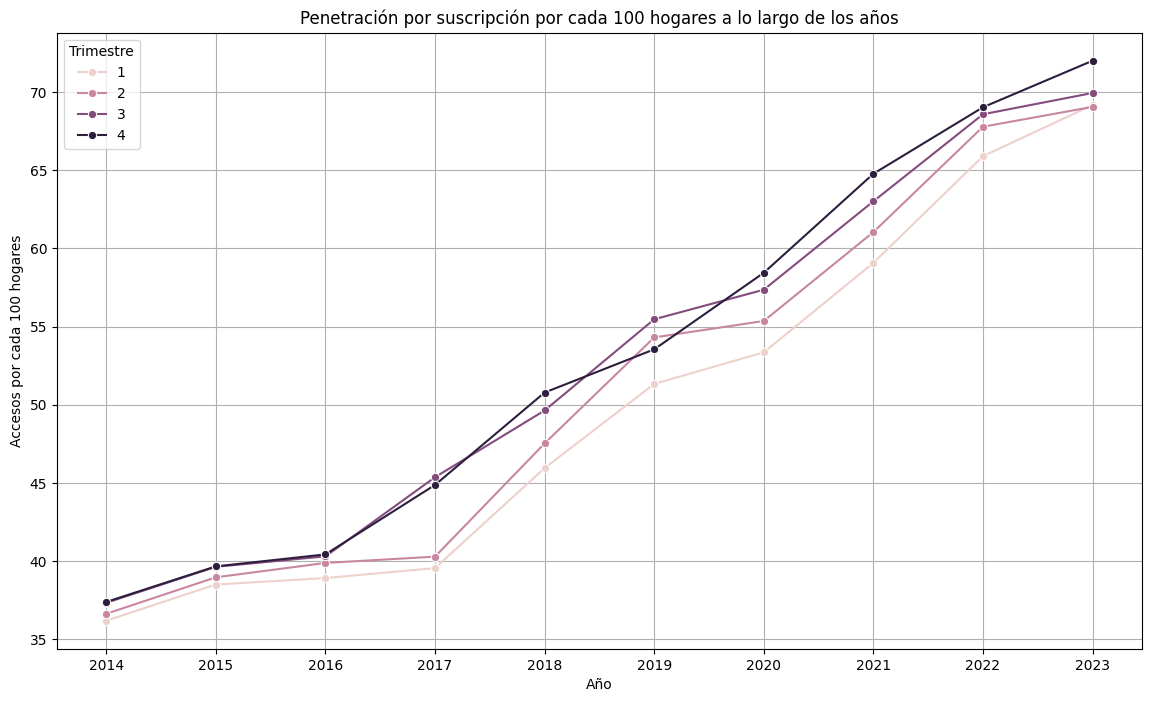

In [11]:
ho_grouped = data_pen_hog.groupby(['Año', 'Trimestre'])['Accesos por cada 100 hogares'].mean().reset_index()

# Gráfico de líneas
plt.figure(figsize=(14, 8))
sns.lineplot(data=ho_grouped, x='Año', y='Accesos por cada 100 hogares', marker='o', hue='Trimestre')

plt.title('Penetración por suscripción por cada 100 hogares a lo largo de los años')
plt.xlabel('Año')
plt.ylabel('Accesos por cada 100 hogares')
plt.xticks(ho_grouped['Año'].unique())
plt.grid(True)
plt.legend(title='Trimestre')
plt.show()

> En una evaluacion general se puede considerar el acceso a los hogares se ha mantenido en un aumento progresivo a traves de la ultima decada.

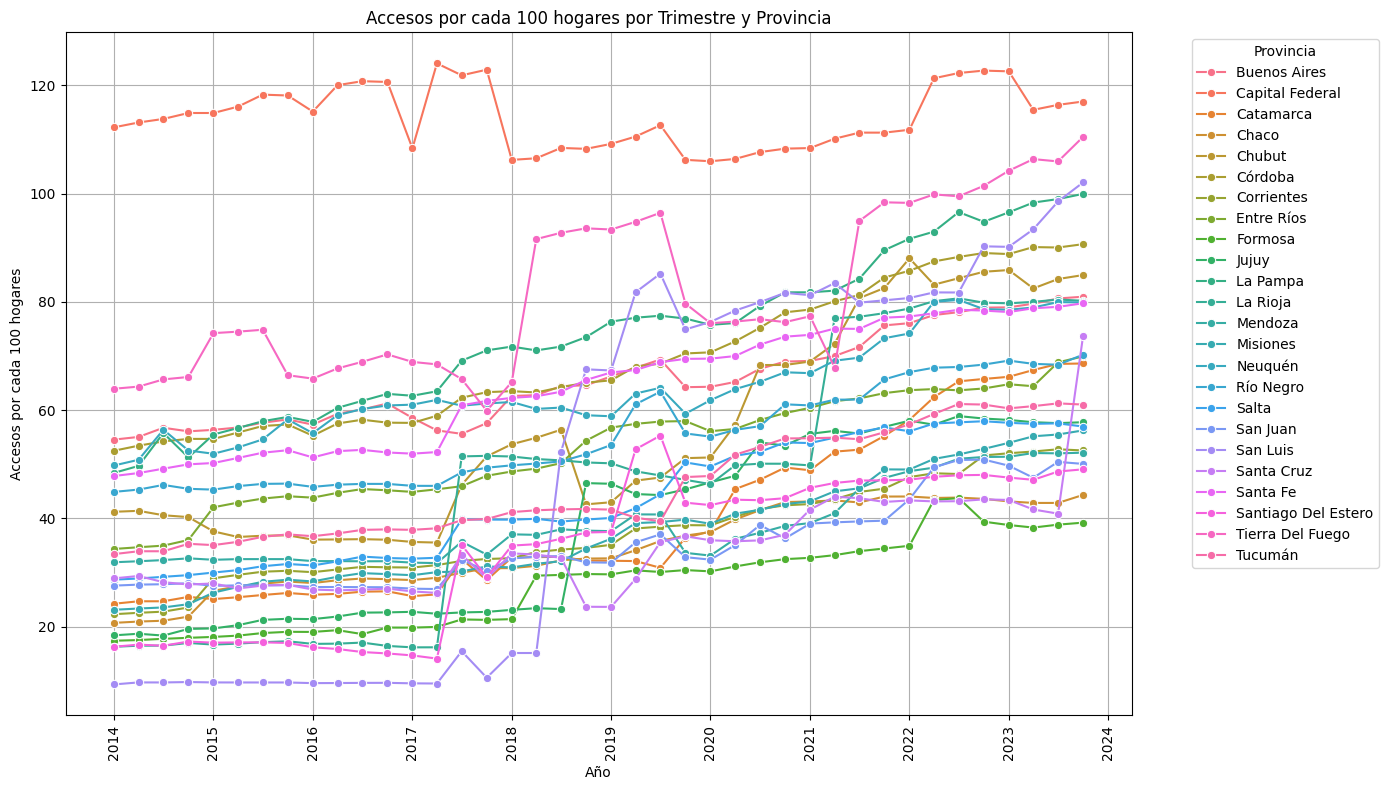

In [12]:
# Crear una función para convertir año y trimestre a una fecha
def convertir_a_date(fila):
    año = fila['Año']
    trimestre = fila['Trimestre']
    if trimestre == 1:
        return pd.Timestamp(f'{año}-01-01')
    elif trimestre == 2:
        return pd.Timestamp(f'{año}-04-01')
    elif trimestre == 3:
        return pd.Timestamp(f'{año}-07-01')
    elif trimestre == 4:
        return pd.Timestamp(f'{año}-10-01')

# Aplicar la función para crear la columna 'Fecha'
data_pen_hog['Fecha'] = data_pen_hog.apply(convertir_a_date, axis=1)


# Crear la gráfica con Seaborn
plt.figure(figsize=(14, 8))
sns.lineplot(data=data_pen_hog, x='Fecha', y='Accesos por cada 100 hogares', hue='Provincia', marker='o')

# Configurar la gráfica
plt.title('Accesos por cada 100 hogares por Trimestre y Provincia')
plt.xlabel('Año')
plt.ylabel('Accesos por cada 100 hogares')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

> En el detalle de los datos por provincia se pueden apreciar los diferentes comportamientos segun sea la provincia, destacando en ella dos en particular, en este caso se tendria la region capital(comportamiento comun), sin embargo quien mas destacaria en este punto seria la provincia de san luis que para mediados del 2017 inicio un crecimiento lento con pasando de aproximadamente un promedio de 10 hogares de manera sostenida desde el 2014 y terminar el año 2017 rozando los 20, pero para el año del 2018 durante su segundo cuarto la provincia de san luis inicia un crecimiento exponencial que decrece solo en el 2019 entre su segundo y tercer cuarto (posiblemente a causa de la pandemia), recupera su linea de crecimiento pero de manera mas lenta para culminar el ultimo cuarto del 2023 con una media que supera el 100.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


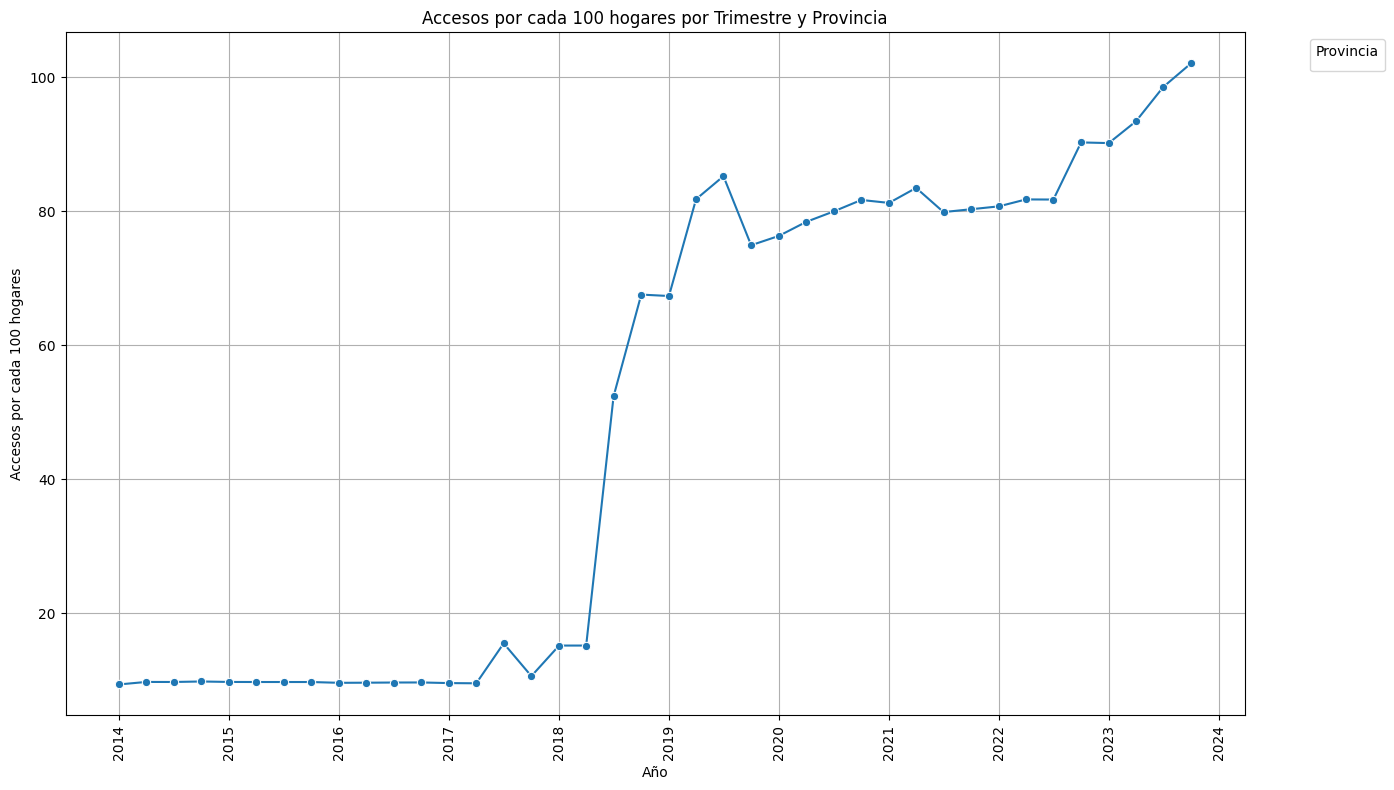

In [13]:
data_=data_pen_hog[data_pen_hog['Provincia']=='San Luis']
data_
# Aplicar la función para crear la columna 'Fecha'
data_['Fecha'] = data_.apply(convertir_a_date, axis=1)


# Crear la gráfica con Seaborn
plt.figure(figsize=(14, 8))
sns.lineplot(data=data_, x='Fecha', y='Accesos por cada 100 hogares', marker='o')

# Configurar la gráfica
plt.title('Accesos por cada 100 hogares por Trimestre y Provincia')
plt.xlabel('Año')
plt.ylabel('Accesos por cada 100 hogares')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [14]:
data_.describe()

,Año,Trimestre,Accesos por cada 100 hogares,Fecha
count,40.000000,40.000000,40.000000,40
mean,2018.500000,2.500000,49.509912,2018-11-15 15:36:00
min,2014.000000,1.000000,9.347208,2014-01-01 00:00:00
25%,2016.000000,1.750000,9.710401,2016-06-08 06:00:00
50%,2018.500000,2.500000,67.444196,2018-11-16 00:00:00
75%,2021.000000,3.250000,81.694609,2021-04-23 18:00:00
max,2023.000000,4.000000,102.070000,2023-10-01 00:00:00
std,2.908872,1.132277,36.485032,NaN


> el valor mas destacado de la tabla Terminaria siendo San Luis con un inicio de 9.34 y un cierre total de 102.07 al final del 2023

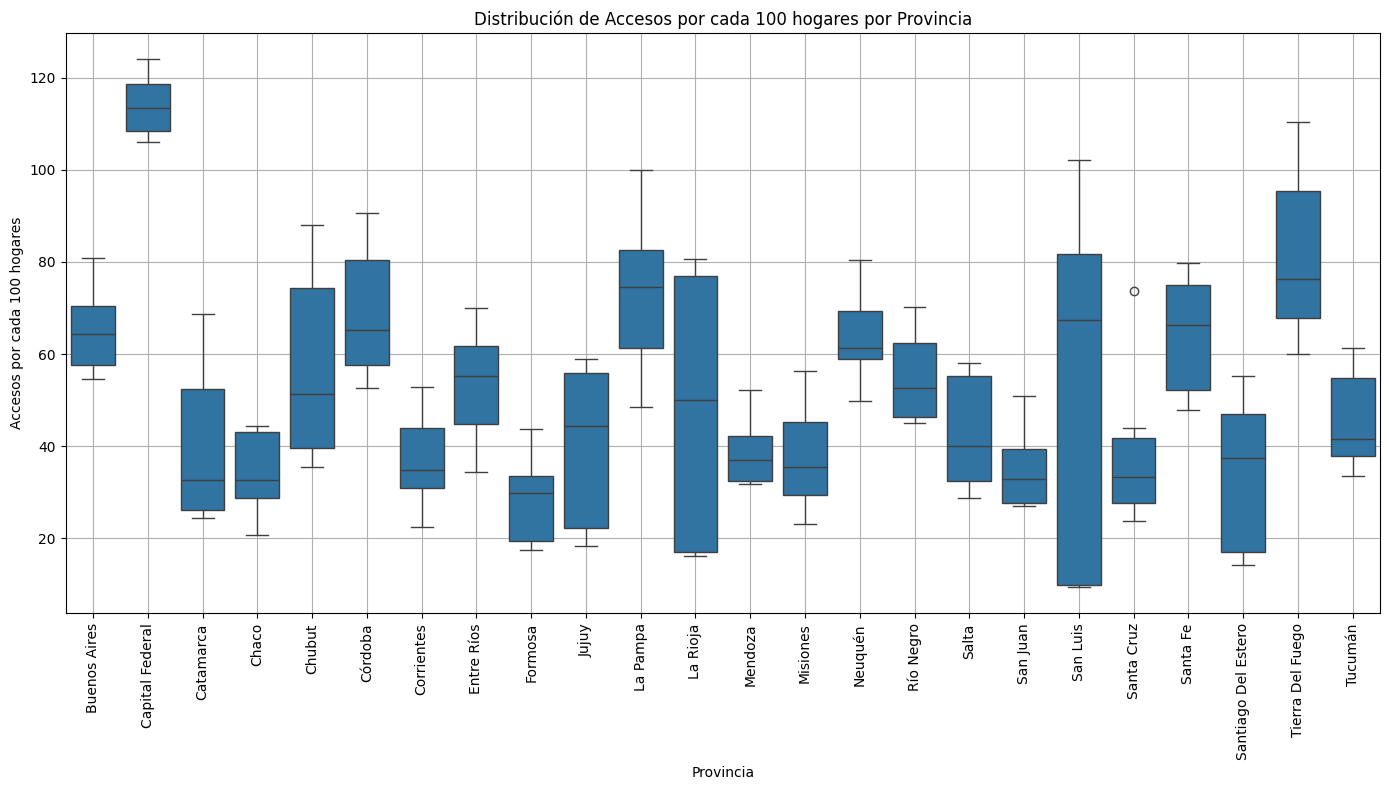

In [15]:
# Crear el boxplot con Seaborn
plt.figure(figsize=(14, 8))
sns.boxplot(data=data_pen_hog, x='Provincia', y='Accesos por cada 100 hogares')

# Configurar la gráfica
plt.title('Distribución de Accesos por cada 100 hogares por Provincia')
plt.xlabel('Provincia')
plt.ylabel('Accesos por cada 100 hogares')
plt.xticks(rotation=90)
plt.grid(True)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

> En el boxplot por provincia podemos detallar un poco mejor el volumen de los datos y podemos percibir un pequeño outlier en la provincia de Santa Cruz, en el cual maneja una media de 30

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


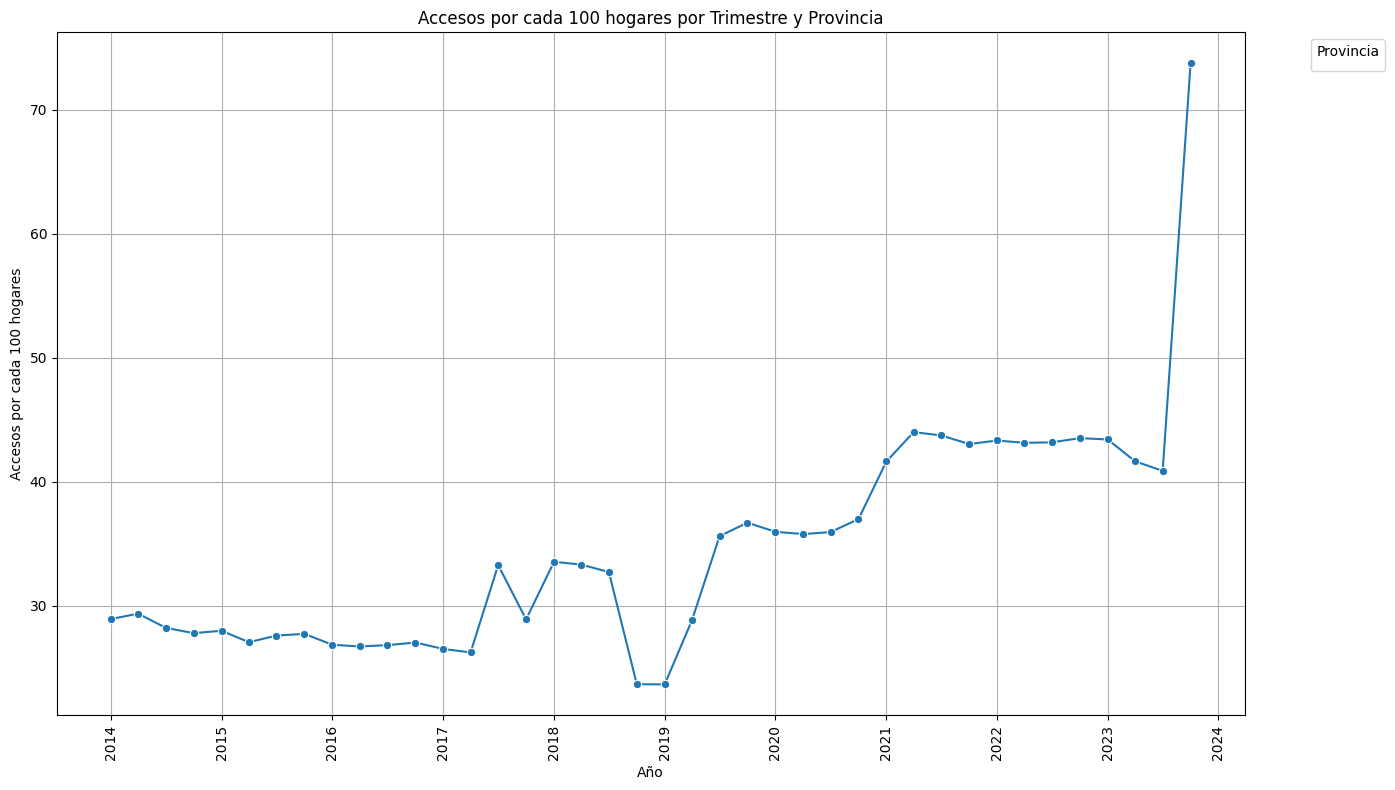

In [16]:
data_=data_pen_hog[data_pen_hog['Provincia']=='Santa Cruz']
data_


# Aplicar la función para crear la columna 'Fecha'
data_['Fecha'] = data_.apply(convertir_a_date, axis=1)


# Crear la gráfica con Seaborn
plt.figure(figsize=(14, 8))
sns.lineplot(data=data_, x='Fecha', y='Accesos por cada 100 hogares', marker='o')

# Configurar la gráfica
plt.title('Accesos por cada 100 hogares por Trimestre y Provincia')
plt.xlabel('Año')
plt.ylabel('Accesos por cada 100 hogares')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(title='Provincia', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [17]:
data_.describe()


,Año,Trimestre,Accesos por cada 100 hogares,Fecha
count,40.000000,40.000000,40.000000,40
mean,2018.500000,2.500000,34.637161,2018-11-15 15:36:00
min,2014.000000,1.000000,23.667655,2014-01-01 00:00:00
25%,2016.000000,1.750000,27.710092,2016-06-08 06:00:00
50%,2018.500000,2.500000,33.312097,2018-11-16 00:00:00
75%,2021.000000,3.250000,41.650873,2021-04-23 18:00:00
max,2023.000000,4.000000,73.750000,2023-10-01 00:00:00
std,2.908872,1.132277,9.255589,NaN


> Para Santa Cruz se puede observar que los datos manejan una media de 34.63 durante el resto de los años, sin embargo en el ultimo trimestre  del 2023 alcanza un pico historico de 73.75, superando por mucho los valores obtenido en años anteriores.

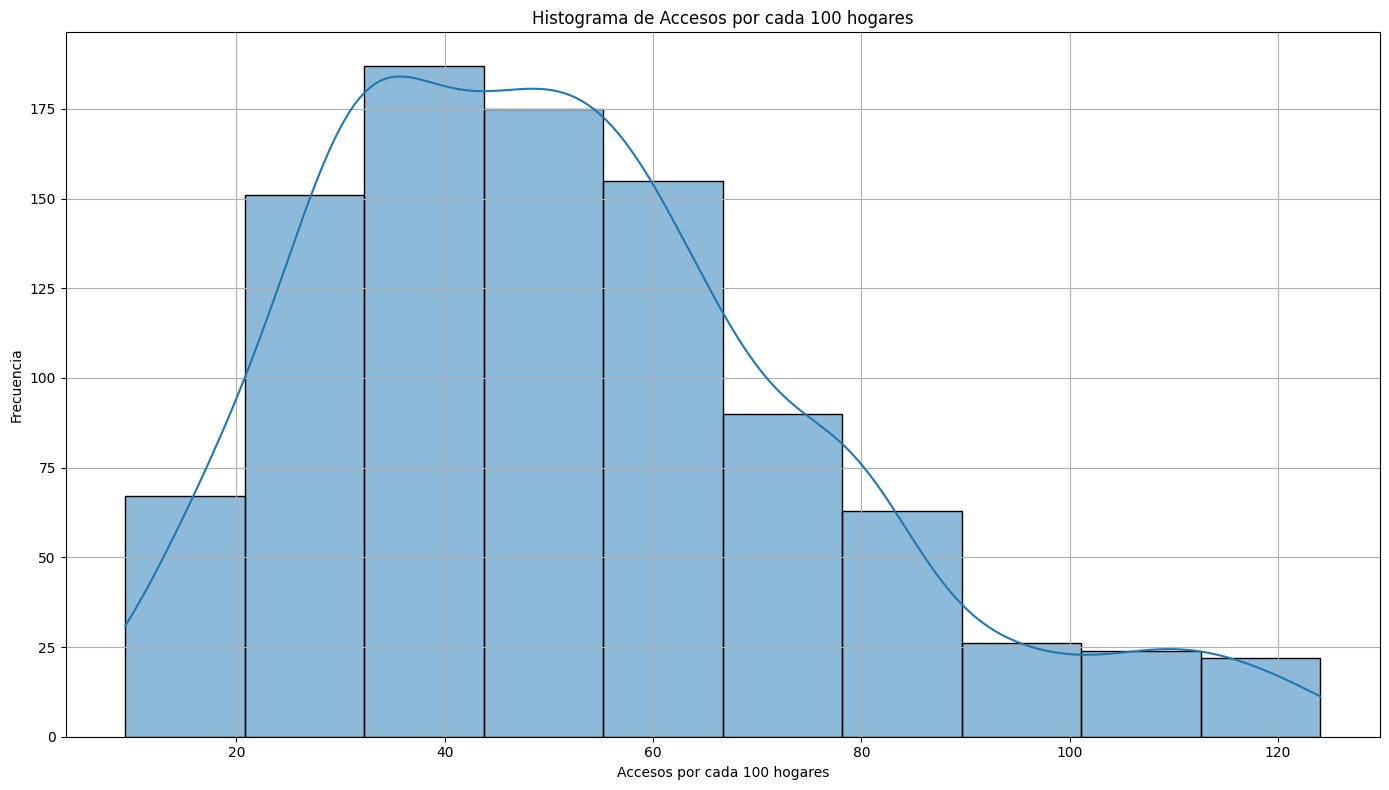

In [18]:
# Crear el histograma con Seaborn
plt.figure(figsize=(14, 8))
sns.histplot(data=data_pen_hog, x='Accesos por cada 100 hogares', bins=10, kde=True)

# Configurar la gráfica
plt.title('Histograma de Accesos por cada 100 hogares')
plt.xlabel('Accesos por cada 100 hogares')
plt.ylabel('Frecuencia')
plt.grid(True)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

> se puede observar una distribución normal en el histograma actual, indicando que en la mayoria de las provincias de Argentina se manejaria un promedio de 38 a 40.

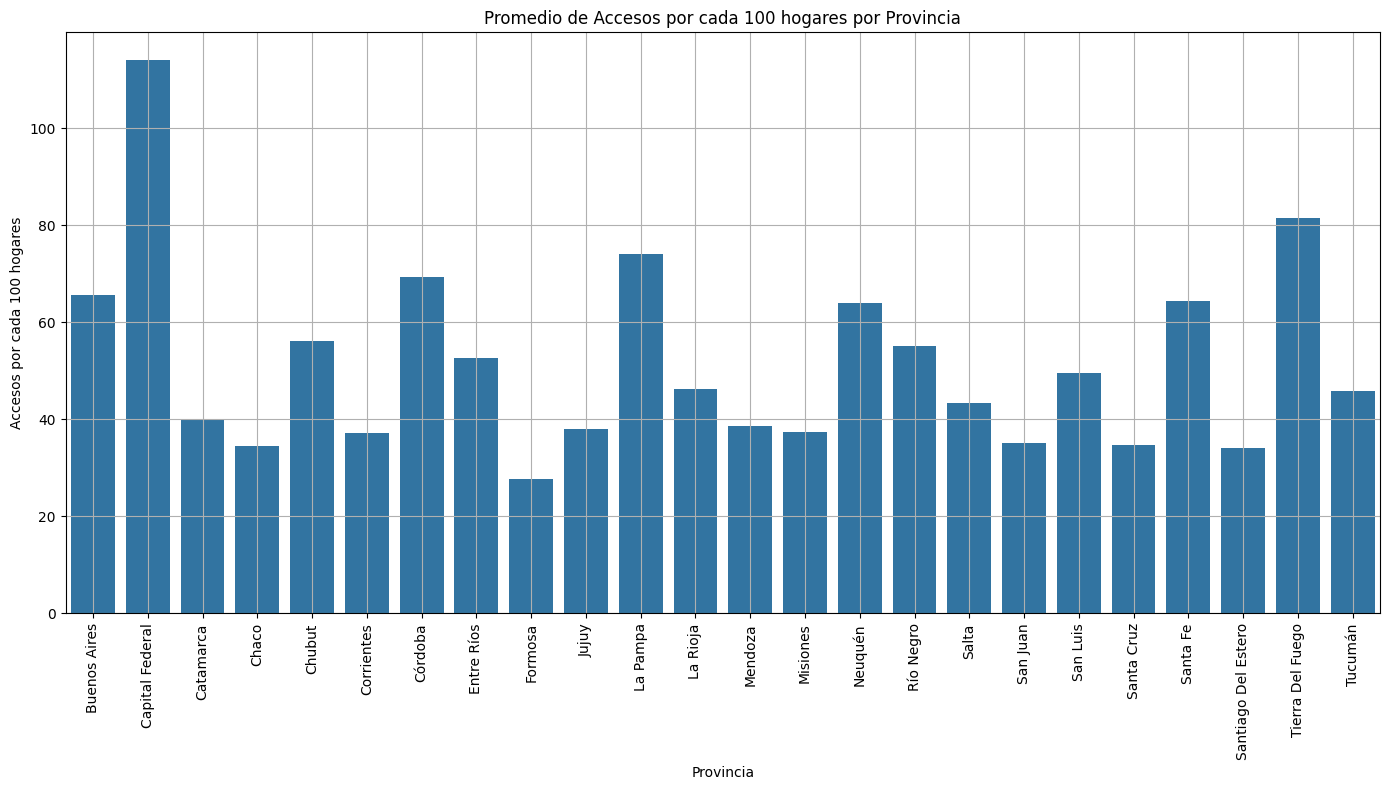

In [19]:
# Crear el gráfico de barras con Seaborn
plt.figure(figsize=(14, 8))
sns.barplot(data=data_pen_hog.groupby('Provincia').mean().reset_index(), x='Provincia', y='Accesos por cada 100 hogares')

# Configurar la gráfica
plt.title('Promedio de Accesos por cada 100 hogares por Provincia')
plt.xlabel('Provincia')
plt.ylabel('Accesos por cada 100 hogares')
plt.xticks(rotation=90)
plt.grid(True)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

> Mediante el grafico de Barras se puede detallar mejor cuales son las provincias que manejan estos valores al final del cierre del 2023, siendo la Capital Federal por mucho con un pico maximo de 124.06 y manteniendo una media de 114.06.

## evaluacion de Acceso por Teconologia

In [20]:
# visualizacion general de la estructura de la tabla
data_acc_por_tec

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
0,2023,4,Buenos aires,223391.0,2797700.0,1784593.0,137993.0,67943.0,5011620.0
1,2023,4,Capital federal,58700.0,1198835.0,182520.0,4492.0,29820.0,1474367.0
2,2023,4,Catamarca,6669.0,11016.0,55437.0,1384.0,81.0,74587.0
3,2023,4,Chaco,14000.0,60277.0,62301.0,8404.0,2404.0,147386.0
4,2023,4,Chubut,26306.0,77217.0,26174.0,30543.0,9930.0,170170.0
...,...,...,...,...,...,...,...,...,...
957,2014,1,Santiago del estero,32567.0,3598.0,19.0,915.0,34.0,37133.0
958,2014,1,Tierra del fuego,21618.0,2837.0,648.0,1.0,2934.0,28038.0
959,2014,1,Tucumán,129717.0,83.0,121.0,13.0,98.0,130032.0
960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> lo primero que resalta en la tabla son los valores nulos, pero estos ya se habian detectado al inicio del estudio, viendo que los datos pertenencen a dos filas que estan practicamente sin informacion se inciara un tratamiento adecuado de los mismos. 

In [21]:
# Filtrar nulos aplicando una mascara
data_acc_por_tec_ = data_acc_por_tec[data_acc_por_tec['Otros'].isnull() == True]
data_acc_por_tec_

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
961,*,Los datos provinciales no coinciden a nivel na...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> Se encuentran dos filas con datos completamente vacios.

In [22]:
# Drop de datos nulos.
data_acc_por_tec = data_acc_por_tec.dropna()

> Se Eliminan las dos ultimas filas ya que su permanencia no aporta ningun dato relevante a la evaluacion de la tabla y por el contrario podria entorpecer los procedimientos a realizarse.

In [23]:
# Mascara para filtrar los datos con error
data_acc_por_tec_ = data_acc_por_tec[data_acc_por_tec['Año'] == '2019 *']
data_acc_por_tec_

,Año,Trimestre,Provincia,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
408,2019 *,3 *,Buenos aires,1277249.0,2144956.0,425386.0,85572.0,27070.0,3960233.0
409,2019 *,3 *,Capital federal,300288.0,1080973.0,24900.0,3895.0,31155.0,1441211.0
410,2019 *,3 *,Catamarca,24349.0,5543.0,13.0,244.0,2251.0,32400.0
411,2019 *,3 *,Chaco,50416.0,49156.0,8063.0,5224.0,1592.0,114451.0
412,2019 *,3 *,Chubut,37298.0,27090.0,1917.0,15149.0,7551.0,89005.0
...,...,...,...,...,...,...,...,...,...
475,2019 *,1 *,Santa cruz,10659.0,4615.0,382.0,6514.0,2735.0,24905.0
476,2019 *,1 *,Santa fe,340038.0,340344.0,15621.0,23215.0,17860.0,737078.0
477,2019 *,1 *,Santiago del estero,25337.0,61547.0,23.0,2847.0,99.0,89853.0
478,2019 *,1 *,Tierra del fuego,19789.0,23549.0,1623.0,0.0,1486.0,46447.0


> Tambien se encuentran datos con un formato errado, en este caso se trada de la columa 'Año' y 'Trimestre' que se encuentran en 'String' con '*' al final.

In [24]:
# Diccionarios para reemplazar valores con errores.
transform_año = {'2019 *':'2019'}
transform_trim = {'1 *':'1', '2 *':'2', '3 *':'3'}

# Aplicacion de map() para reemplazar varores con error.
data_acc_por_tec['Año'] = data_acc_por_tec['Año'].map(lambda x: transform_año.get(x, x))
data_acc_por_tec['Trimestre'] = data_acc_por_tec['Trimestre'].map(lambda x: transform_trim.get(x, x))

# Cambiar el tipo de datos a las columnas.
data_acc_por_tec['Año'] = data_acc_por_tec['Año'].astype('int64')
data_acc_por_tec['Trimestre'] = data_acc_por_tec['Trimestre'].astype('int64')

> Mediante el metodo .map() de pandas se reemplazan los valores con errores y para poder ejecutar de mejor manera las evaluaciones de los datos.

In [25]:
# Normalizar y limpiar la columna categorica de Provincia.
data_acc_por_tec['Provincia'] = data_acc_por_tec['Provincia'].str.strip().str.capitalize()

> Se aplica el metodo .strip() y .capitalize() a la columna categorica de 'Provincia' con el fin de normalizarla y tener un formato de trabajo estandar para las consultas.

In [26]:
# Visualizar los detalles de la tabla.
data_acc_por_tec.info()

<class 'pandas.core.frame.DataFrame'>
Index: 960 entries, 0 to 959
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Año           960 non-null    int64  
 1   Trimestre     960 non-null    int64  
 2   Provincia     960 non-null    object 
 3   ADSL          960 non-null    float64
 4   Cablemodem    960 non-null    float64
 5   Fibra óptica  960 non-null    float64
 6   Wireless      960 non-null    float64
 7   Otros         960 non-null    float64
 8   Total         960 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 75.0+ KB


> De esta manera se encuentran los datos de la tabla posterior a la limpieza, con un total de registros de 960, 9 variables que se subdividen en 2 numericas de formato entero, 6 numericas de formato punto flotante y una categorica.

In [27]:
# Evaluacion de los datos numericos de la columna.
data_acc_por_tec.describe()

,Año,Trimestre,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total
count,960.000000,960.000000,9.600000e+02,9.600000e+02,9.600000e+02,960.00000,960.000000,9.600000e+02
mean,2018.500000,2.500000,1.171007e+05,1.816350e+05,4.428212e+04,12071.28750,6451.996875,3.615411e+05
std,2.873778,1.118617,2.411026e+05,4.461057e+05,1.681546e+05,20544.30774,11192.518329,7.778954e+05
min,2014.000000,1.000000,3.296000e+03,0.000000e+00,0.000000e+00,0.00000,2.000000,1.255700e+04
25%,2016.000000,1.750000,2.123025e+04,1.054450e+04,3.470000e+02,676.00000,330.000000,5.900025e+04
50%,2018.500000,2.500000,4.547550e+04,3.967000e+04,2.541000e+03,4947.00000,1881.000000,1.111385e+05
75%,2021.000000,3.250000,9.190500e+04,7.549325e+04,2.347675e+04,13694.25000,7278.750000,1.883518e+05
max,2023.000000,4.000000,1.586343e+06,2.797700e+06,1.784593e+06,138405.00000,73415.000000,5.011620e+06


In [28]:
# Imprimir tabla de total de accesos por tecnologia.
data_total_acc_por_tec

,Año,Trimestre,ADSL,Cablemodem,Fibra óptica,Wireless,Otros,Total,Periodo
0,2023,4,836390,6022532,3908183,585760,194796,11547661,Oct-Dic 2023
1,2023,3,897895,6018832,3708718,581436,200027,11406908,Jul-Sept 2023
2,2023,2,1006509,5997149,3463988,581823,202428,11251897,Abr-Jun 2023
3,2023,1,1204417,6002582,3243411,576647,214838,11241895,Ene-Mar 2023
4,2022,4,1315373,6037457,3060575,572969,221740,11208114,Oct-Dic 2022
5,2022,3,1395277,6031970,2871541,557110,235230,11091128,Jul-Sept 2022
6,2022,2,1468333,5979214,2723285,556243,231609,10958684,Abr-Jun 2022
7,2022,1,1533240,6073426,2219533,545814,251996,10624009,Ene-Mar 2022
8,2021,4,1657615,5984240,2072236,523107,252596,10489794,Oct-Dic 2021
9,2021,3,1950631,5826257,1566048,492415,250190,10085541,Jul-Sept 2021


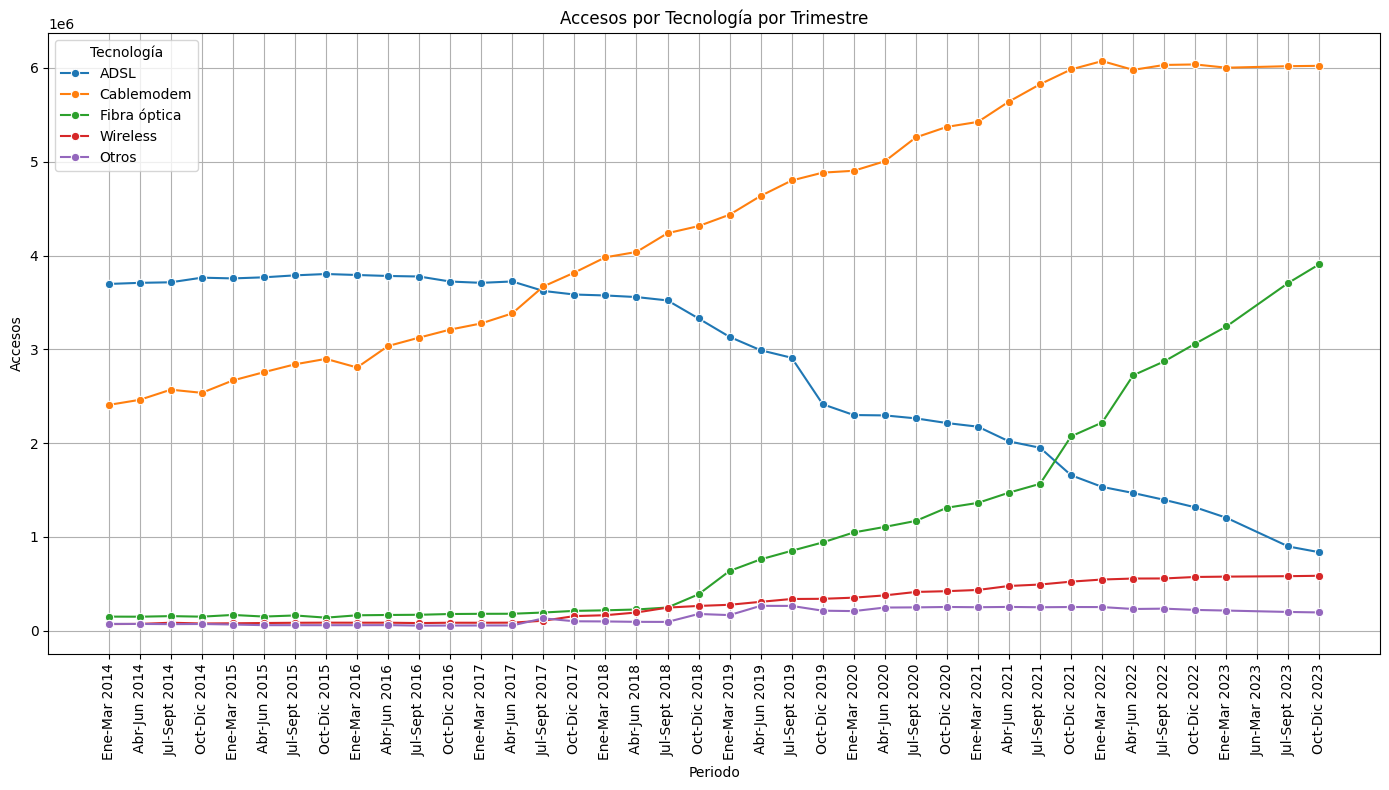

In [29]:
# Transformar el DataFrame a formato largo
df_melt = data_total_acc_por_tec.melt(id_vars=['Año', 'Trimestre', 'Periodo'], value_vars=['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros'], var_name='Tecnología', value_name='Accesos')

# Ordenar el DataFrame por el período en orden ascendente
df_melt['Periodo'] = pd.Categorical(df_melt['Periodo'], categories=df['Periodo'][::-1], ordered=True)

# Crear la gráfica con Seaborn
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_melt, x='Periodo', y='Accesos', hue='Tecnología', marker='o')

# Configurar la gráfica
plt.title('Accesos por Tecnología por Trimestre')
plt.xlabel('Periodo')
plt.ylabel('Accesos')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(title='Tecnología')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

> Para el grafico de la los tipos de tecnologias por provincia se puede notar que para el incio del año 2014 se la tecnologia de ADSL era quien mayor demanda mantenia en ese momento pero manenia una medida sostenida, mientras que cablemodem se mantenia de en segundo plano pero con una una pendiente que indicaba un aumento a lo largo del tiempo, esto hasta el 2017 que seria la fecha en donde las linas de progrecion temporal de cada tecnologia llegan a cruzarse es donde se nota que ADSL inicia su descenso, de manera vertiginosa. per lo realmente relevante en este punto es que mediante este mismo grafico se puede observar una correlacion inversamente proporcional existente entre las tecnologias, ya que a medida que una va en aumento y esta alcanza cierto punto el resto empieza a descender, lo que llevaria a considerar el comportamiento que tenido la tecnologia de      <strong> Fibra optica </strong> durante el segunto y el cuarto trimestre del 2018, en el cual demuestra un crecimiento exponencia aun mayor que la del Cablemodem.

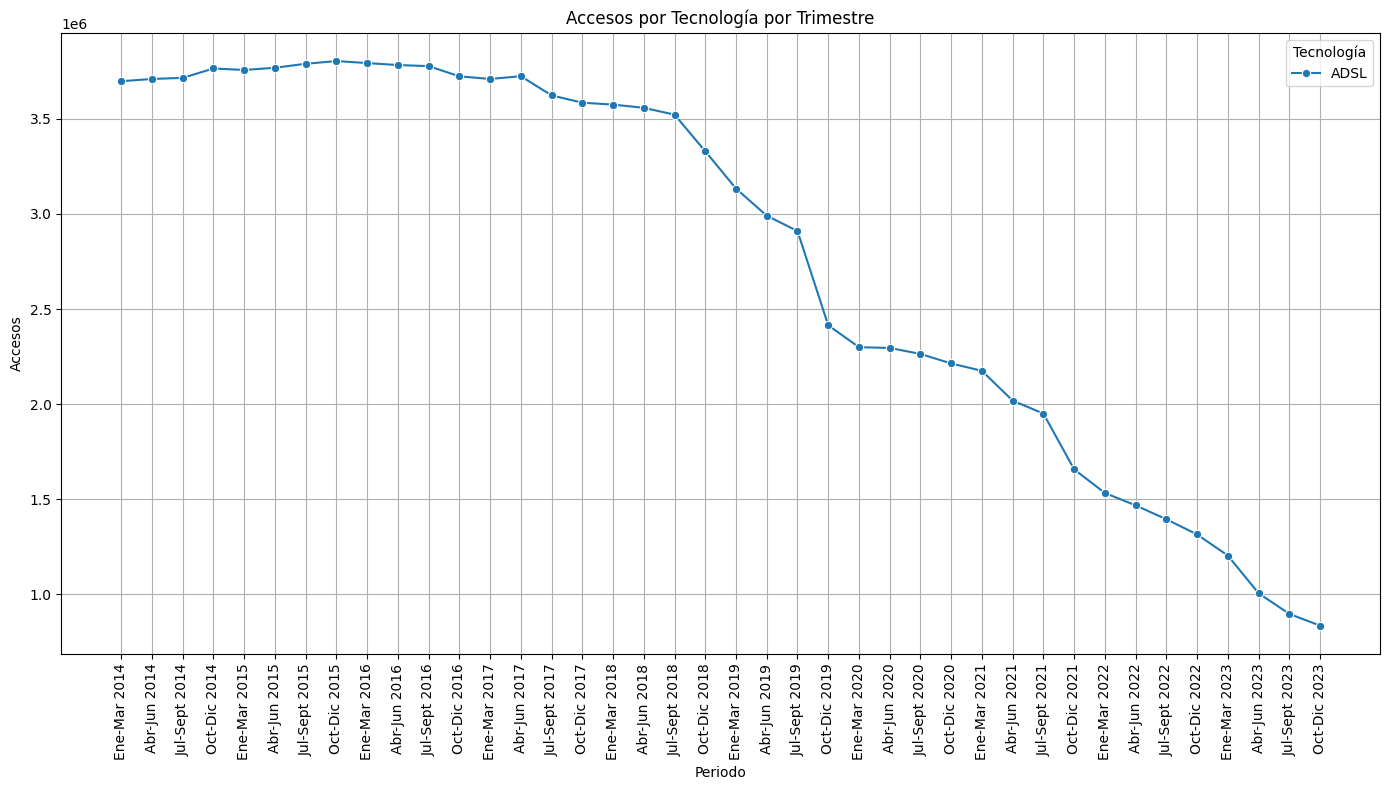

In [30]:
# Transformar el DataFrame a formato largo
df_melt_2 = data_total_acc_por_tec.melt(id_vars=['Año', 'Trimestre', 'Periodo'], value_vars=['ADSL'], var_name='Tecnología', value_name='Accesos')

# Ordenar el DataFrame por el período en orden ascendente
df_melt_2['Periodo'] = pd.Categorical(df_melt_2['Periodo'], categories=df_melt_2['Periodo'][::-1], ordered=True)

# Crear la gráfica con Seaborn
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_melt_2, x='Periodo', y='Accesos', hue='Tecnología', marker='o')

# Configurar la gráfica
plt.title('Accesos por Tecnología por Trimestre')
plt.xlabel('Periodo')
plt.ylabel('Accesos')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(title='Tecnología')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

> En esta Grafica se puede ver mas claramente el descenso que ha tenido la tecnologia ADSL hasta finales del año 2023

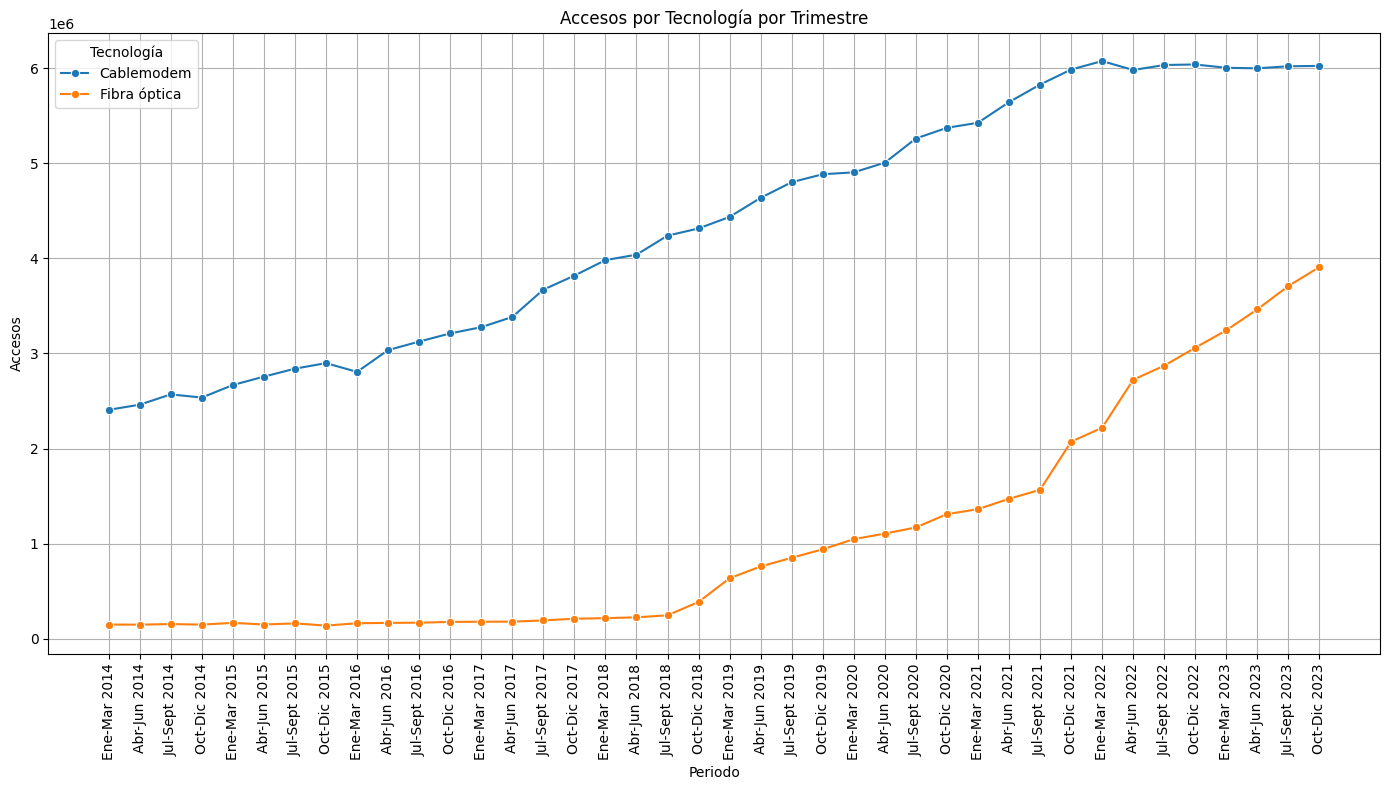

In [31]:
# Transformar el DataFrame a formato largo
df_melt_3 = data_total_acc_por_tec.melt(id_vars=['Año', 'Trimestre', 'Periodo'], value_vars=['Cablemodem', 'Fibra óptica'], var_name='Tecnología', value_name='Accesos')

# Ordenar el DataFrame por el período en orden ascendente
df_melt_3['Periodo'] = pd.Categorical(df_melt_3['Periodo'], categories=data_total_acc_por_tec['Periodo'][::-1], ordered=True)

# Crear la gráfica con Seaborn
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_melt_3, x='Periodo', y='Accesos', hue='Tecnología', marker='o')

# Configurar la gráfica
plt.title('Accesos por Tecnología por Trimestre')
plt.xlabel('Periodo')
plt.ylabel('Accesos')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(title='Tecnología')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

> En la Grafica siguiente se comparan las lineas de tiempo de <strong>Cablemodem</strong> y <strong>Fibra Optica</strong>, demostando en ella lo mencionado anteriormente, de la tendencia al crecimiento y la estabilizacion de la tecnologia cablemodem a partir del año 2022, mientas que la fibra optica mantiene su crecimiento.

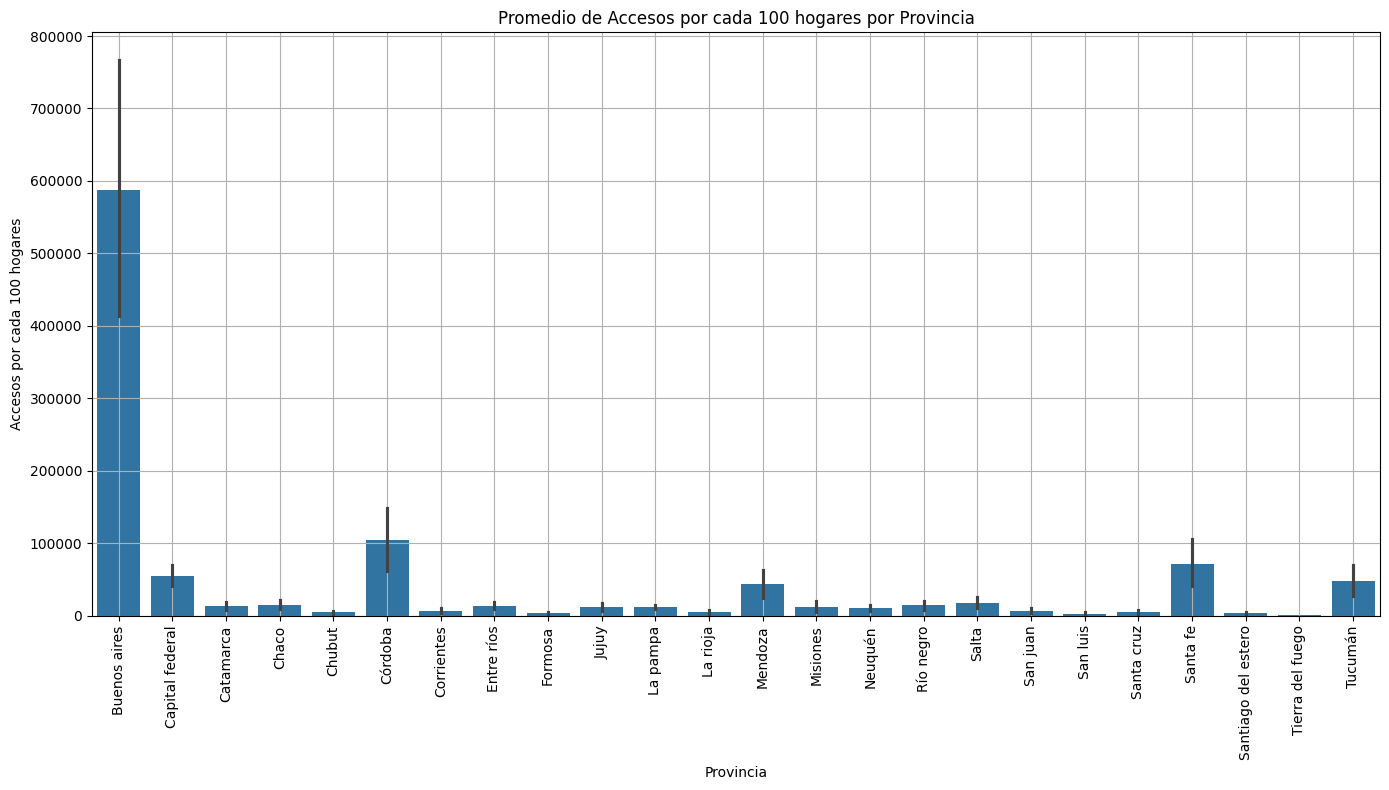

In [32]:
# Crear el gráfico de barras con Seaborn
plt.figure(figsize=(14, 8))
sns.barplot(data=data_acc_por_tec, x='Provincia', y='Fibra óptica')

# Configurar la gráfica
plt.title('Promedio de Accesos por cada 100 hogares por Provincia')
plt.xlabel('Provincia')
plt.ylabel('Accesos por cada 100 hogares')
plt.xticks(rotation=90)
plt.grid(True)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

<p> Sin embargo se puede visualizar la ausencia de conexiones de <strong> Fibra optica </strong> en la mayoria de las provincias concentrandose en su mayoria solamente en Buenos Aires, lo que haria suponer que posiblemente sea un problema de infraestructura la ausencia de conexiones de fibra en las diferentes provincias al rededor del pais.

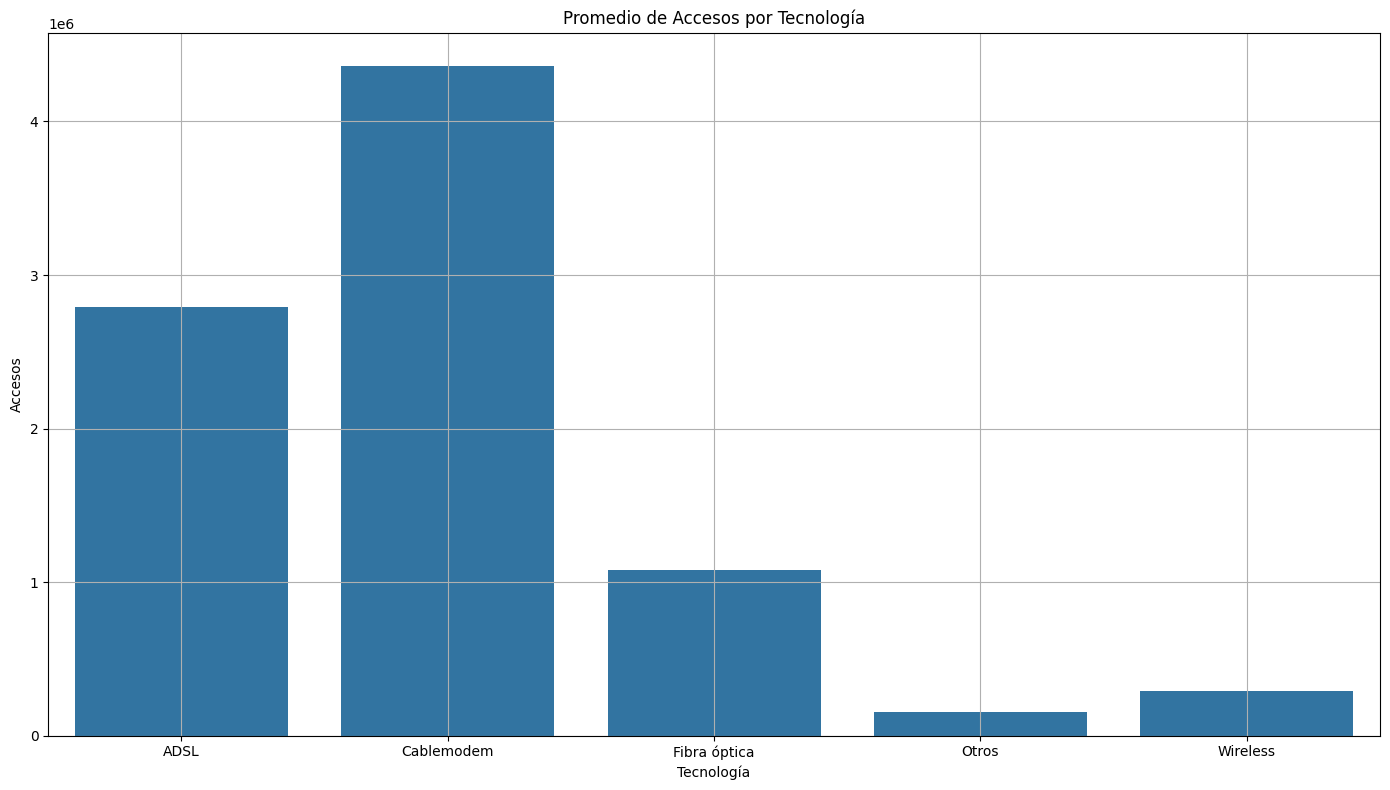

In [33]:
# Calcular el promedio de accesos por tecnología
df_mean = df_melt.groupby('Tecnología')['Accesos'].mean().reset_index()

# Crear el gráfico de barras con Seaborn
plt.figure(figsize=(14, 8))
sns.barplot(data=df_mean, x='Tecnología', y='Accesos')

# Configurar la gráfica
plt.title('Promedio de Accesos por Tecnología')
plt.xlabel('Tecnología')
plt.ylabel('Accesos')
plt.grid(True)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

> en el siguiente grafioco se piede observar el comportamiento de las tecnologias mediante el tipo de tecnologias, con respecto a sus maximos de conexiones logradas. manteniendose muy por encima el cablemodem con respecto a los demas tipos de tecnologias, seguido del ADSL, sin embargo en el grafico anterio se pudo detallar de mejor manera como el cablemodem ha venido disminuyendo en el transcurso de los años.

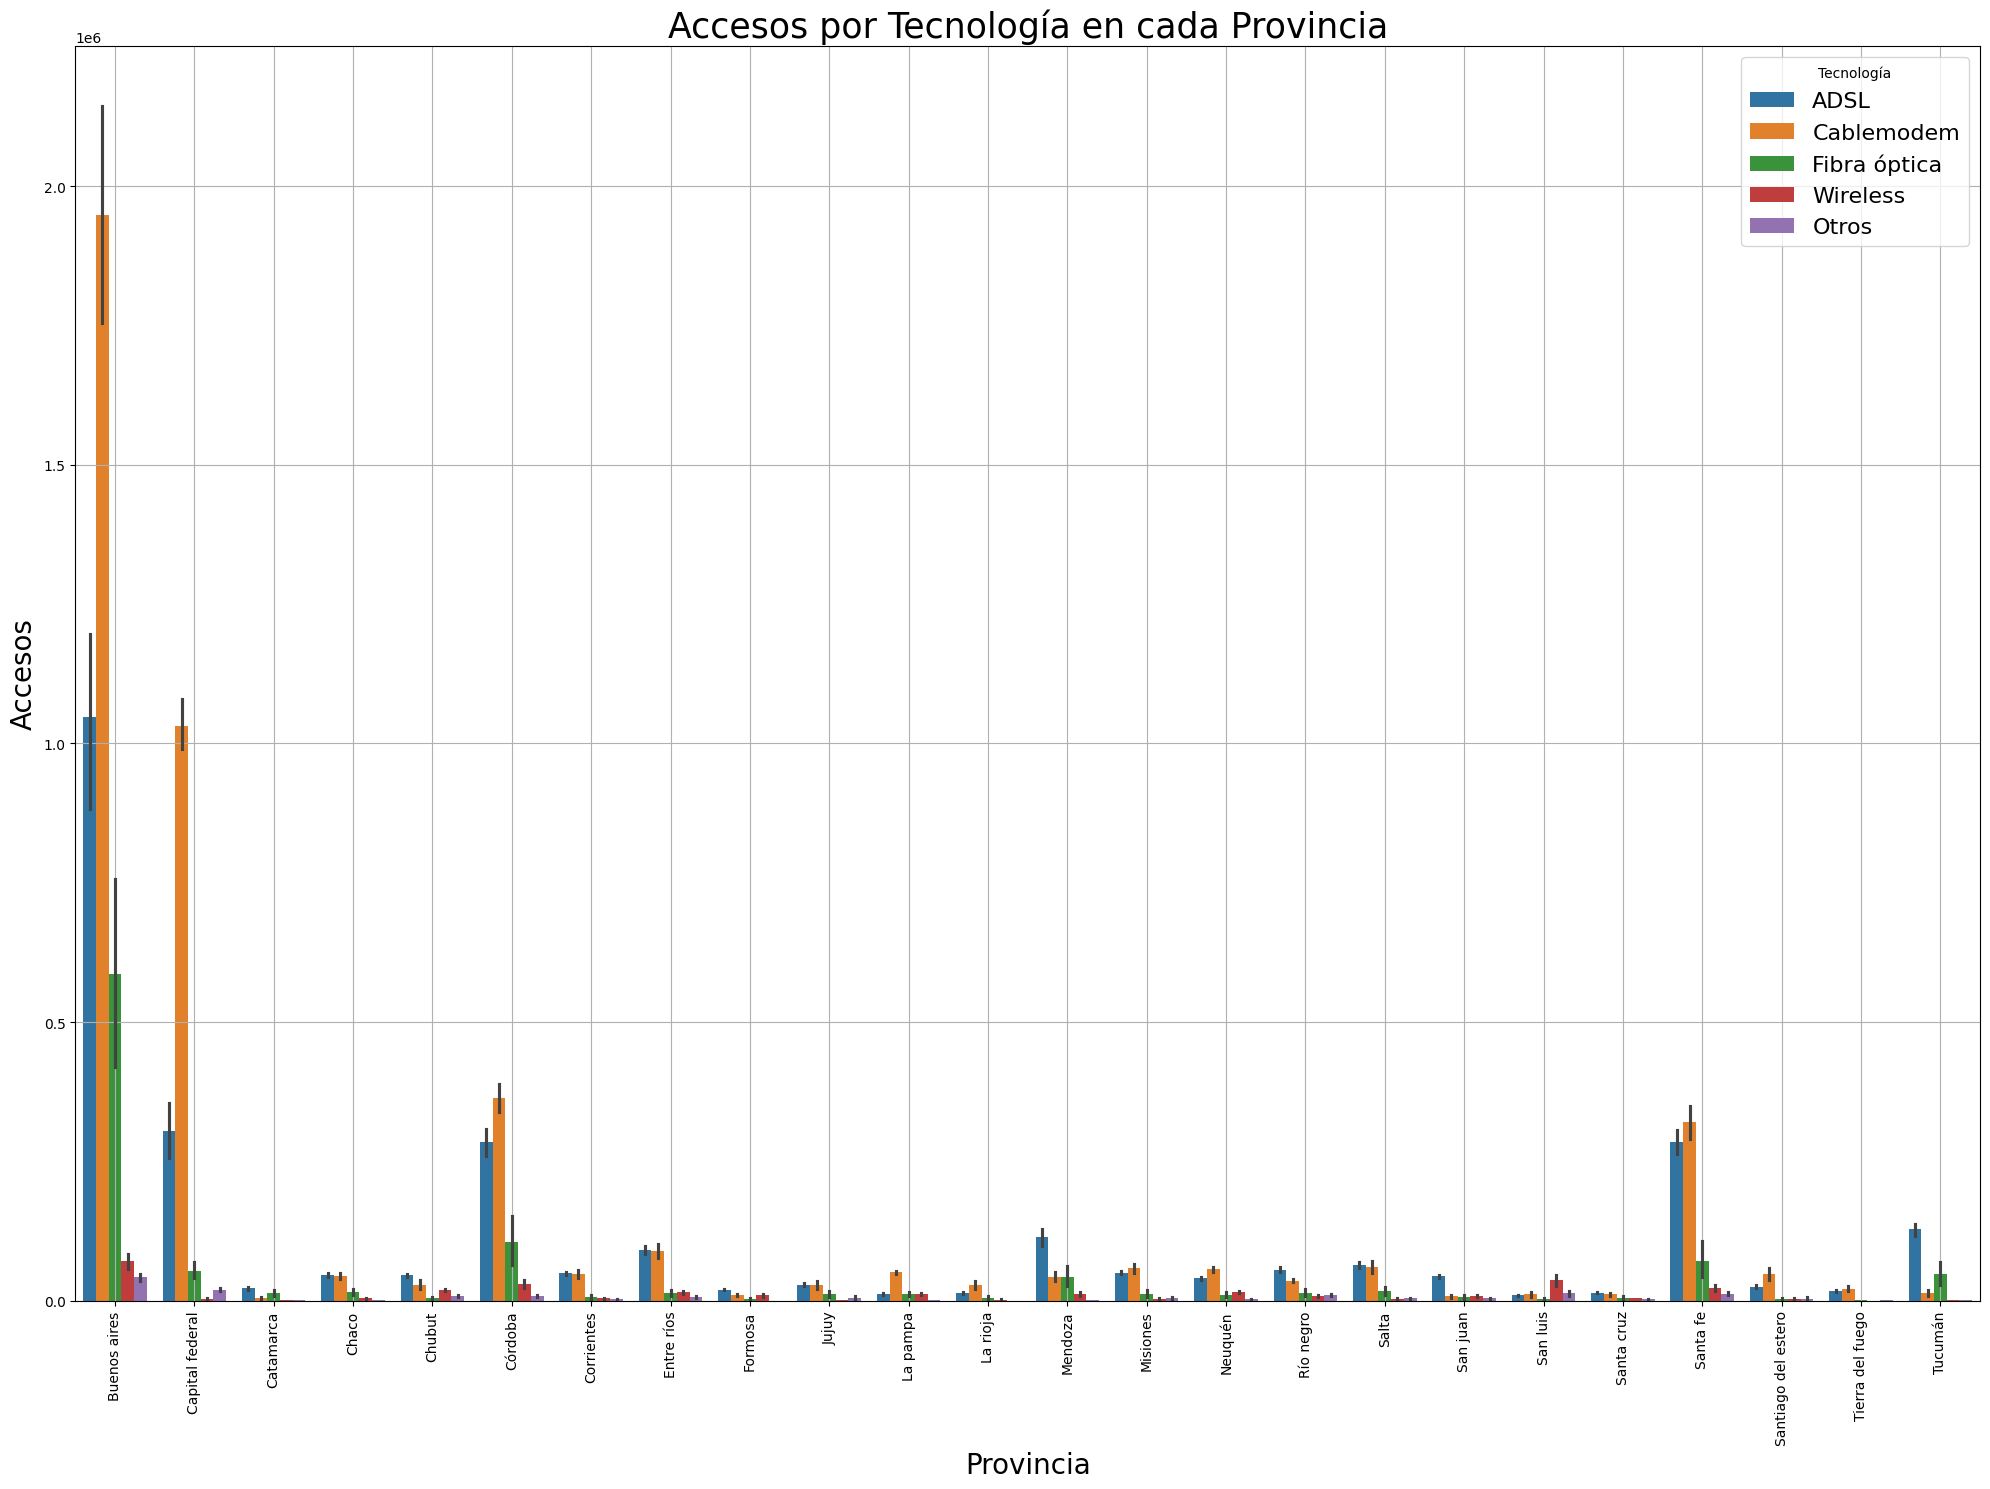

In [34]:
df_melt= data_acc_por_tec.melt(id_vars=['Año', 'Trimestre', 'Provincia'], 
                                              value_vars=['ADSL', 'Cablemodem', 'Fibra óptica', 'Wireless', 'Otros'], 
                                              var_name='Tecnología', value_name='Accesos')

# Aumentar el tamaño de la figura
plt.figure(figsize=(20, 15))

# Crear el gráfico de barras
sns.barplot(data=df_melt, x='Provincia', y='Accesos', hue='Tecnología')

# Configurar la gráfica
plt.title('Accesos por Tecnología en cada Provincia', fontsize=25)
plt.xlabel('Provincia', fontsize=20)
plt.ylabel('Accesos', fontsize=20)
plt.xticks(rotation=90)
plt.legend(title='Tecnología', fontsize=16)
plt.grid(True)

# Mostrar la gráfica
plt.tight_layout()
plt.show()

> En la siguiente presentacion se puede contemplar el comportamiento de las fiferentes tecnologias con respecto a las provincias, demostrando lo que se planteaba en el punto anterior, que actualmente <strong> Cablemodem</strong> tiene una mayor presencia en la region capital, seguido de            <strong> ADSL</strong> quien ha venido diminuyendo su presencia, pero se manitne aun en gran parte del interior del pais como la principal de las tecnologias, y seguido por <strong> Fibra Optica</strong> quien mantiene su curva de crecimiento segun lo observado en la seccion anterior.

## Evaluacion de los datos de Acceso por Velocidad.

In [35]:
# Visualizacion de la estructura de la tabla.
data_acc_por_vel

,Año,Trimestre,Provincia,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps,OTROS,Total
0,2024,4,Buenos Aires,26909.0,23962.0,228393.0,239339.0,246144.0,110876.0,4042646.0,93351.0,5011620.0
1,2024,4,Capital Federal,516.0,4544.0,26409.0,48083.0,33925.0,5829.0,1355061.0,0.0,1474367.0
2,2024,4,Catamarca,71.0,209.0,3065.0,3734.0,4423.0,1827.0,61181.0,77.0,74587.0
3,2024,4,Chaco,236.0,477.0,14811.0,10361.0,6247.0,5729.0,105485.0,4040.0,147386.0
4,2024,4,Chubut,111.0,1088.0,44276.0,31402.0,22843.0,20196.0,33665.0,16589.0,170170.0
...,...,...,...,...,...,...,...,...,...,...,...,...
955,2014,1,Santa Cruz,161.0,1625.0,24972.0,1.0,1.0,0.0,0.0,0.0,26760.0
956,2014,1,Santa Fe,8456.0,124468.0,345225.0,20328.0,6845.0,23.0,668.0,0.0,506013.0
957,2014,1,Santiago Del Estero,1234.0,10531.0,22817.0,2422.0,109.0,0.0,0.0,0.0,37113.0
958,2014,1,Tierra Del Fuego,12.0,607.0,30902.0,6.0,0.0,0.0,0.0,0.0,31527.0


In [36]:
# Visualizacion del total de acceso por velocidad.
data_total_acc_vel

,Año,Trimestre,Hasta 512 kbps,Entre 512 Kbps y 1 Mbps,Entre 1 Mbps y 6 Mbps,Entre 6 Mbps y 10 Mbps,Entre 10 Mbps y 20 Mbps,Entre 20 Mbps y 30 Mbps,Más de 30 Mbps,OTROS,Total
0,2024,4,29708,71742,900253,978108,697232,350290,8224736,295592,11547661
1,2023,3,30274,80609,945608,998725,720084,350918,8003269,277421,11406908
2,2023,2,30827,79405,963510,1028250,734125,364730,7775095,275955,11251897
3,2023,1,31437,82048,1001553,1060321,729194,357769,7564819,414754,11241895
4,2022,4,31981,85668,1075272,1109421,765015,335573,7410902,394282,11208114
5,2022,3,33013,96727,1161370,1151906,823505,479822,6995750,349035,11091128
6,2022,2,33667,99498,1193090,1197030,856562,485321,6741922,351594,10958684
7,2022,1,34890,104840,1263273,1209148,967508,509830,6336187,198333,10624009
8,2021,4,41262,28521,1413208,1245333,976539,558358,6032322,194251,10489794
9,2021,3,40174,41437,2550229,1095772,710122,536364,4948174,163269,10085541


Tambien se observa que algunos registros de la columna año tienen 2024, sin embargo mediante el estudio de los datos se puede deducir que ha sido un error de tipeo, por lo cual el registro debe ser 2023.

In [37]:
# Diccionarios para reemplazar valores con errores.
transform_año = {2024: 2023}

# Aplicacion de map() para reemplazar varores con error.
data_acc_por_vel['Año'] = data_acc_por_vel['Año'].map(lambda x: transform_año.get(x, x))
data_total_acc_vel['Año'] = data_total_acc_vel['Año'].map(lambda x: transform_trim.get(x, x))



> Se realiza el reemplazo de los valores errados y se imprimen las tablas para verificar.

In [38]:
data_acc_por_vel.head(5)

,Año,Trimestre,Provincia,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps,OTROS,Total
0,2023,4,Buenos Aires,26909.0,23962.0,228393.0,239339.0,246144.0,110876.0,4042646.0,93351.0,5011620.0
1,2023,4,Capital Federal,516.0,4544.0,26409.0,48083.0,33925.0,5829.0,1355061.0,0.0,1474367.0
2,2023,4,Catamarca,71.0,209.0,3065.0,3734.0,4423.0,1827.0,61181.0,77.0,74587.0
3,2023,4,Chaco,236.0,477.0,14811.0,10361.0,6247.0,5729.0,105485.0,4040.0,147386.0
4,2023,4,Chubut,111.0,1088.0,44276.0,31402.0,22843.0,20196.0,33665.0,16589.0,170170.0


In [39]:
data_total_acc_vel.head(5)

,Año,Trimestre,Hasta 512 kbps,Entre 512 Kbps y 1 Mbps,Entre 1 Mbps y 6 Mbps,Entre 6 Mbps y 10 Mbps,Entre 10 Mbps y 20 Mbps,Entre 20 Mbps y 30 Mbps,Más de 30 Mbps,OTROS,Total
0,2024,4,29708,71742,900253,978108,697232,350290,8224736,295592,11547661
1,2023,3,30274,80609,945608,998725,720084,350918,8003269,277421,11406908
2,2023,2,30827,79405,963510,1028250,734125,364730,7775095,275955,11251897
3,2023,1,31437,82048,1001553,1060321,729194,357769,7564819,414754,11241895
4,2022,4,31981,85668,1075272,1109421,765015,335573,7410902,394282,11208114


In [40]:
data_acc_por_vel.describe()

,Año,Trimestre,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps,OTROS,Total
count,960.000000,960.000000,960.000000,960.000000,9.600000e+02,960.000000,960.000000,960.000000,9.600000e+02,954.000000,9.600000e+02
mean,2018.500000,2.500000,1986.276042,9291.107292,1.371885e+05,38112.431250,37303.288542,20197.090625,1.098851e+05,6081.618449,3.600074e+05
std,2.873778,1.118617,12889.165297,21018.938200,3.281748e+05,64565.358974,89536.515407,70534.758485,4.347858e+05,14541.341682,7.740852e+05
min,2014.000000,1.000000,6.000000,0.000000,1.483000e+03,0.000000,0.000000,0.000000,0.000000e+00,-1945.000000,1.240600e+04
25%,2016.000000,1.750000,40.750000,347.250000,2.451150e+04,3581.000000,2127.500000,36.750000,1.075000e+01,0.000000,5.882400e+04
50%,2018.500000,2.500000,107.000000,2263.500000,4.425400e+04,12913.500000,10082.000000,1391.500000,2.418500e+03,92.000000,1.097050e+05
75%,2021.000000,3.250000,468.000000,7227.500000,8.439500e+04,40126.000000,26436.000000,9858.750000,3.533225e+04,6489.750000,1.880792e+05
max,2023.000000,4.000000,238920.000000,171244.480000,2.299705e+06,403575.000000,886678.000000,949093.000000,4.042646e+06,122762.000000,5.011620e+06


In [41]:
# normalizacion de la columna categirica 'Provincia'.
data_acc_por_vel['Provincia'] = data_acc_por_vel['Provincia'].str.strip().str.capitalize()

> Con el fin de mantener un estandar de las columnas categoricas se realiza una normalizacion con el metodo strip() y el metodo capitalize().

In [42]:
data_acc_por_vel_ = data_acc_por_vel[data_acc_por_vel['OTROS'].isnull() == True]
data_acc_por_vel_ 

,Año,Trimestre,Provincia,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps,OTROS,Total
433,2019,2,Capital federal,74.0,1027.0,281370.0,124087.0,239691.0,296155.0,475991.0,NaN,1418395.0
443,2019,2,La rioja,9.0,11.0,39819.0,4297.0,4857.0,13.0,1298.0,NaN,50304.0
444,2019,2,Mendoza,20.0,2522.0,205165.0,2971.0,10092.0,1256.0,234.0,NaN,222260.0
451,2019,2,Santa cruz,25.0,84.0,24861.0,3806.0,1202.0,28.0,4.0,NaN,30010.0
454,2019,2,Tierra del fuego,6.0,123.0,41824.0,4241.0,1573.0,96.0,32.0,NaN,47895.0
455,2019,2,Tucumán,16.0,157.0,78891.0,44296.0,24291.0,628.0,18394.0,NaN,166673.0


> Mediante la evaluacion de los datos que se realizo de manera preliminar se precibieron 6 datos nulos en la columna 'OTROS' de la tabla, por ello se realiza directamente el filtro para ver el estado de las filas y segun lo que se pudo observar es posible rellenar las filas con el valor 0 (cero) y no variaria el total que se maneja en los datos.

In [43]:
# Tratamiento de datos nulos.
data_acc_por_vel['OTROS'] = data_acc_por_vel['OTROS'].fillna(0)


In [44]:
data_acc_por_vel_ = data_acc_por_vel[data_acc_por_vel['OTROS'].isnull() == True]
data_acc_por_vel_ 

,Año,Trimestre,Provincia,HASTA 512 kbps,+ 512 Kbps - 1 Mbps,+ 1 Mbps - 6 Mbps,+ 6 Mbps - 10 Mbps,+ 10 Mbps - 20 Mbps,+ 20 Mbps - 30 Mbps,+ 30 Mbps,OTROS,Total


> Resultado: la tabla no contiene datos nulos.

In [45]:
data_acc_por_vel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Año                  960 non-null    int64  
 1   Trimestre            960 non-null    int64  
 2   Provincia            960 non-null    object 
 3   HASTA 512 kbps       960 non-null    float64
 4   + 512 Kbps - 1 Mbps  960 non-null    float64
 5   + 1 Mbps - 6 Mbps    960 non-null    float64
 6   + 6 Mbps - 10 Mbps   960 non-null    float64
 7   + 10 Mbps - 20 Mbps  960 non-null    float64
 8   + 20 Mbps - 30 Mbps  960 non-null    float64
 9   + 30 Mbps            960 non-null    float64
 10  OTROS                960 non-null    float64
 11  Total                960 non-null    float64
dtypes: float64(9), int64(2), object(1)
memory usage: 90.1+ KB


> con el metodo info() de pandas se evalua a la composicion y los formatos de las columnas de la tabla, arrojando como resultado un total  de 960 registros, 1 columna categorica, 2 columnas de datos numericos enteros y 9 columna de datos numericos de punto flotante.

Año	Trimestre	Hasta 512 kbps	Entre 512 Kbps y 1 Mbps	Entre 1 Mbps y 6 Mbps	Entre 6 Mbps y 10 Mbps	Entre 10 Mbps y 20 Mbps	Entre 20 Mbps y 30 Mbps	Más de 30 Mbps	OTROS	Total

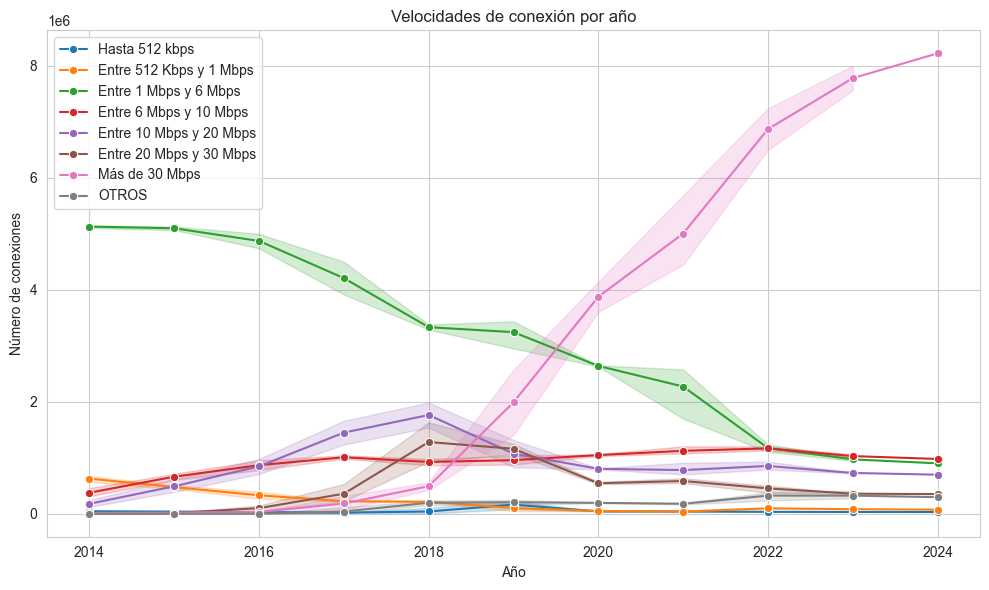

In [46]:
plt.figure(figsize=(10, 6))

# Configurar el estilo de Seaborn
sns.set_style('whitegrid')

# Convertir los datos a formato largo (long format)
df_melt= pd.melt(data_total_acc_vel.drop(columns=['Total']), id_vars=['Año', 'Trimestre'], var_name='Categoría', value_name='Número de conexiones')

# Trama de líneas para cada categoría de velocidad
sns.lineplot(x='Año', y='Número de conexiones', hue='Categoría', data=df_melt, marker='o')

# Ajustes de la gráfica
plt.title('Velocidades de conexión por año')
plt.xlabel('Año')
plt.ylabel('Número de conexiones')
plt.legend(loc='upper left')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

> Desde el 2014 hasta el 2018 Puede observarse un que en su mayoria las velocidades de conexion se mantenian casi en el mismo nivel, salvo por la conexion de rango  1 a 6 Mbps, sin embargo se tiene un crecimiento exponencial en el 2018 de las conexiones de mas de 30 Mbps, analizando las graficas anteriores se puede interpretar que ha esta tendencia mantiene una relacion directa con el incremento de conexiones mediante <strong>Fibra Optica</strong>, durante el tercer trimestre del año 2018 dicha tecnologia inicia tambien su escalada y mientras que las demas conexiones mantienen el mismo patron, 

In [50]:
# Vamos a agrupar por provincia y sumar las tecnologías a lo largo de los años
df_grouped = data_acc_por_vel.groupby('Provincia').sum().reset_index()

# Seleccionar las columnas relevantes para la visualización
tecnologias = ['HASTA 512 kbps', '+ 512 Kbps - 1 Mbps', '+ 1 Mbps - 6 Mbps',
               '+ 6 Mbps - 10 Mbps', '+ 10 Mbps - 20 Mbps', '+ 20 Mbps - 30 Mbps',
               '+ 30 Mbps', 'OTROS']

# Filtrar el dataframe para seleccionar solo las tecnologías de interés
df_plot = df_grouped[tecnologias + ['Provincia']]

# Asegurar que los valores estén ordenados según la columna de provincias
df_plot = df_plot.sort_values(by='Provincia')

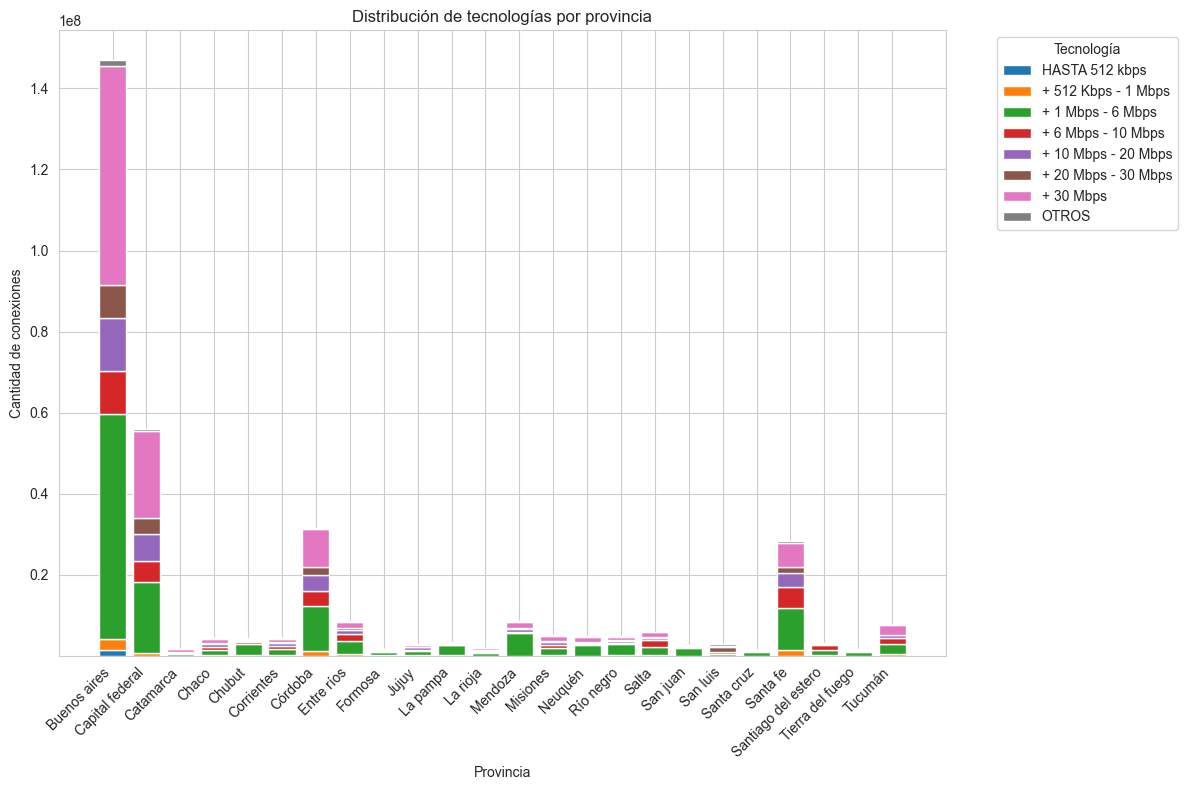

In [51]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 8))

# Crear el gráfico de barras apiladas
bottom = None
for tecnologia in tecnologias:
    ax.bar(df_plot['Provincia'], df_plot[tecnologia], label=tecnologia, bottom=bottom)
    if bottom is None:
        bottom = df_plot[tecnologia].values
    else:
        bottom += df_plot[tecnologia].values

# Personalización del gráfico
ax.set_xlabel('Provincia')
ax.set_ylabel('Cantidad de conexiones')
ax.set_title('Distribución de tecnologías por provincia')
ax.legend(title='Tecnología', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotar las etiquetas del eje x para mejor visualización si hay muchas provincias
plt.xticks(rotation=45, ha='right')

# Mostrar la gráfica
plt.tight_layout()
plt.grid(True)
plt.show()

## Conclusion:

<p>A traves del analisis profundo de los datos reunidos se puede llegar a deducir los siguientes puntos: </p>
<ol>
    <li>El Acceso a las conexiones se mantiene en constante crecimiento, independientemente de la tecnologia que se implemente para ello, cabe destacar que el nivel de acceso a una u otra dependera totalmente de la infraestructura que maneje cada provincia.</li>
    <li>La correlacion Inversamente proporcional entre el comportamiento de las tecnologias a lo largo del tiempo, lo que supone una ventaja al momento de intentar predecir el comportamiento futuro de las mismas.</li>
    <li>La correlacion entre tecnologia y las velocidades son proporcionales entre si, en este punto es importante indicar que el nivel de acceso de una tecnologia en una provincia impactara directamente a la velocidad de conexion que resalte en la misma.</li>
    <li>De manera general se puede deducir que desde el año 2014, (a pesar que la tecnologia <strong>ADSL</strong> se mantuvo con mayor alcance hasta el 2017) <strong>Cablemodem</strong> mantuvo su constante crecimiento hasta estabilizarse en 2022, esto puede deberse al aumento a gran velocidad que ha tenido la <strong>Fibra Optica</strong> desde el año 2018.</li>
</ol>
